Direct binary classification with optimum model - Random Forest
Used to see how it performs on dataset containing duplicates

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
features = df[df.columns[3:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [4]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10], 'max_features': ['auto', 'sqrt'], \
             'min_samples_leaf': [1, 2, 4]}

In [9]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=40, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.9899402612817537
grid_kfold_shuffle: test set average accuracy:  0.9917960738353355 



In [11]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.9624927685532475
grid_kfold_shuffle test set average precision:  0.9784467660559595 



In [12]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.9980750581544802
grid_kfold_shuffle test set AUC:  0.9989569968130458 



In [5]:
# confusion matrix (max_depth=8)
#best parameters for average precision

from sklearn.metrics import confusion_matrix

forest = RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=0)
forest.fit(X_train, y_train)
predict = forest.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(y_test[y_test==0]))*100
major_error = (confusion[1][0]/len(y_test[y_test==1]))*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

# begins creates list for model comparison:
direct_VME = very_major_error
direct_ME = major_error

Precision:  0.9428571428571428
Sensitivity:  0.8918918918918919
Specificity:  0.9975497702909648
FPR : 0.00245022970903519
very major error : 0.2450229709035222
major error:  10.81081081081081

 confusion matrix: 
 [[3257    8]
 [  16  132]]


{0: 3273, 1: 140}


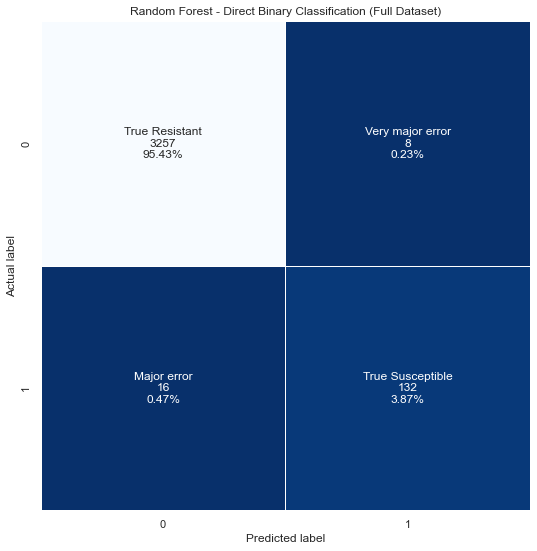

In [7]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest - Direct Binary Classification (Full Dataset)');
plt.savefig('figures/full_dataset_matrix_RF.png')

C:\Users\user\AppData\Local\Temp/ipykernel_16952/2662661847.py:28: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_16952/2662661847.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_16952/2662661847.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_16952/2662661847.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))


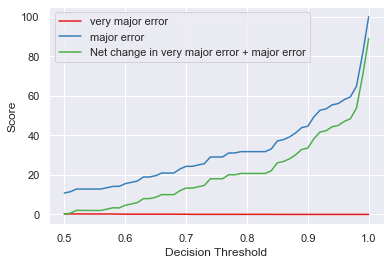

Optimum threshold to reduce very major error without     increasing major error by more than 1.5x :
 0.53


In [29]:
# graph showing how major and very major error changes with decision threshold
import matplotlib.pyplot as plt
threshold  = np.linspace(0.5,1,num = 51)
very_major_error = []
major_error = []
net_error_change = []
threshold_shift = []

forest = RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=0)
forest.fit(X_train, y_train)
predicted_proba = forest.predict_proba(X_test)

predict = (predicted_proba[:,1] >= 0.5).astype('int')
confusion = confusion_matrix(y_test, predict)
og_very_major_error = ((confusion[0][1]/len(y_test[y_test==0]))*100)
og_major_error = ((confusion[1][0]/len(y_test[y_test==1]))*100)

for i in threshold:
    predict = (predicted_proba[:,1] >= i).astype('int')
    confusion = confusion_matrix(y_test, predict)
    very_major_error.append((confusion[0][1]/len(y_test[y_test==0]))*100)
    major_error.append((confusion[1][0]/len(y_test[y_test==1]))*100)

    #code to mathematically determine optimum threshold shifting
    vm_error_cost = ((confusion[0][1]/len(y_test[y_test==0]))*100) - og_very_major_error
    m_error_cost = ((confusion[1][0]/len(y_test[y_test==1]))*100) - og_major_error
    net_error_change.append(m_error_cost + vm_error_cost)
    grad_change = (m_error_cost / (-1*vm_error_cost))
    if grad_change <= 1.5:
        threshold_shift.append(i)
    
    
    
plt.plot(threshold, very_major_error, label = 'very major error')
plt.plot(threshold, major_error, label = 'major error')
plt.plot(threshold, net_error_change, label = 'Net change in very major error + major error')

plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend()
plt.show()

if threshold_shift == []:
    optimum_thresh = 0.5
    print('Shifting does not improve results')
else:
    optimum_thresh = max(threshold_shift)
    print('Optimum threshold to reduce very major error without \
    increasing major error by more than 1.5x :\n'\
        ,max(threshold_shift))

In [30]:
# shift threshold accoriding to data above - optimum theshold to decrease FPR without
# increasing major error by more than 1.5 x
# = ~0.53


# NOTE - shift actually makes the model worse here, there is no change in FPR and a slight increase
# in major error

forest = RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
forest.fit(X_train, y_train)
predicted_proba = forest.predict_proba(X_test)
predict = (predicted_proba[:,1] >= optimum_thresh).astype('int')
confusion = confusion_matrix(y_test, predict)

Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(y_test[y_test==0]))*100
major_error = (confusion[1][0]/len(y_test[y_test==1]))*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)

print ('\n confusion_matrix: \n', confusion)

Precision:  0.9402985074626866
Sensitivity:  0.8513513513513513
Specificity:  0.9975497702909648
FPR : 0.00245022970903519
very major error : 0.2450229709035222
major error:  14.864864864864865

 confusion_matrix: 
 [[3257    8]
 [  22  126]]


Model without shifting is best

Has excpetional very major error and low major error - better than all other models

But, this is influenced by the extremely high rate of S315T (3100/3400 in test set)